# QSDE Solver

Here I'll try to implement a quantum circuit to solve a Quantum Stochastic Differential Equation (QSDE) for a two level atom driven by a laser. This will be based on 
Visser and Bouten 2019: arXiv:1811.09657 [quant-ph].

Here $\sigma_{x,y,z}$ are Pauli operators and $\sigma_{+,-}$ are raising and lowering operators of the atom. 

The QSDE is a Markovian unitary process given as

$dU(t) = \big( \sqrt{\kappa}(\sigma_- \otimes dB^{\dagger}(t) - \sigma_+ \otimes dB(t)) - (i(\omega \sigma_+ \sigma_- + \frac{\Omega}{2}\sigma_y) + \frac{\kappa}{2}\sigma_+ \sigma_-)\otimes \mathbb{1}_{field}dt  \big) U(t)$

where $\kappa$ is decay rate, $\omega$ is the transition frequency of the atom, $\Omega$ is the Rabi frequency,dB(t) is the bosonic field infintesimal and $\mathbb{1}_{field}$ is the identity operator in the field's Hilbert space.

SInce a unitary transform is essentially a rotation on the wavevector, then we can represent the unitary operator as

U(t) = $M_N$ $M_{N-1}$ ... $M_1 M_2 $,

where $M_i$ is the ith slice of the unitary process and N is the last slice in the time interval [0,T]. 

Here they introduce linear operators $M^0, M^1, M^2, and M^3$ that decomposes as
$M_i - \mathbb{1} = M^3 \otimes \Delta \Lambda(t) + M^2 \otimes \Delta B^{\dagger}(t) + M^1 \otimes \Delta B(t)   + M^0\otimes \Delta t  $. 

Given that $\lambda = \sqrt{\frac{T}{N}}$ then the discrete increments of quantum noise are as follows
$\Delta B(i) = \lambda (\sigma_-)_i ; \Delta B^\dagger(i) = \lambda (\sigma_-)_i ; \Delta \Lambda(i) = (\sigma_+ \sigma_-)_i ; \Delta t(i) = \lambda^2 \mathbb{1}_i$.

In [1]:
import numpy as np
from qiskit import *
from sympy import *
from math import pi
from qiskit.circuit import Parameter
%matplotlib inline

In [2]:
# Visualization packages
from qiskit.visualization import plot_state_city, plot_bloch_vector,plot_histogram
import matplotlib.pyplot as plt

In [3]:
# Import from Qiskit Aer noise module
from qiskit.providers.aer.noise import NoiseModel
from qiskit.providers.aer.noise import QuantumError, ReadoutError
from qiskit.providers.aer.noise import pauli_error
from qiskit.providers.aer.noise import depolarizing_error
from qiskit.providers.aer.noise import thermal_relaxation_error

## noise simulator
from qiskit.test.mock import FakeVigo
device_backend = FakeVigo()

In [4]:
# Aer's qasm_simulator
backend_sim = Aer.get_backend('qasm_simulator')
backend_vec = Aer.get_backend('statevector_simulator')
backend_uni = Aer.get_backend('unitary_simulator')
backend_noise = backend_sim.from_backend(device_backend)

In [5]:
# Register circuit (total qubits in the network)
q_1 = QuantumRegister(2) # quantum bit for z measurement
c_1 = ClassicalRegister(2) # classical bit for z measurement
# Register circuit (total qubits in the network)


In [6]:
# Parameters
kappa = 1
bigomega = 12
omega = 0
T_total = 1

# Initial conditions
rho_init = np.array([[0,0],[0,1]])
sigma_x = np.array([[0,1],[1,0]]) ; sigma_y = np.array([[0,-1j],[1j,0]]) ; sigma_z = np.array([[1,0],[0,-1]]) 

In [7]:
## Computation parameters
N = 100
time_step = T_total/N
time_range = np.linspace(0,T_total,N)

#qiskit parameters
N_counts = 10240

# additional parameters
lam = np.sqrt(time_step)

The linear operators $M^0, M^1, M^2,$ and $M^3$ are defiend below. This is by guess accroding to the paper

In [8]:
def m0_mat(lam,kap,w,bw):
    M0mat = np.matrix([[(np.exp(-1j*w*lam**2)*np.cos(np.sqrt(kap)*lam)*np.cos(bw*lam**2/2) - 1)/(lam**2),-(np.exp(- 1j*w*lam**2)*np.cos(np.sqrt(kap)*lam)*np.sin(bw*lam**2/2))/(lam**2)],[(np.sin(bw*lam**2/2))/(lam**2), (np.cos(bw*lam**2/2) - 1)/(lam**2)]])
    return M0mat

In [9]:
def m1_mat(lam,kap,w,bw):
    M1mat = np.matrix([[(np.sin(np.sqrt(kap)*lam)*np.sin(bw*lam**2/2))/lam, -(np.sin(np.sqrt(kap)*lam)*np.cos(bw*lam**2/2))/lam],[0,0]])
    return M1mat

In [10]:
def m2_mat(lam,kap,w,bw):
    M2mat = np.matrix([[0,0],[(np.exp(-1j*w*lam**2)*np.sin(np.sqrt(kap)*lam)*np.cos(bw*lam**2/2))/lam,-(np.exp(-1j*w*lam**2)*np.sin(np.sqrt(kap)*lam)*np.sin(bw*lam**2/2))/lam]])
    return M2mat

In [11]:
def m3_mat(lam,kap,w,bw):
    M3mat = np.matrix([[np.exp(-1j*w*lam**2)*(1-np.cos(np.sqrt(kap)*lam))*np.cos(bw*lam**2/2),np.exp(-1j*w*lam**2)*(np.cos(np.sqrt(kap)*lam)-1)*np.sin(bw*lam**2/2)],[(np.cos(np.sqrt(kap)*lam)-1)*np.sin(bw*lam**2/2),(np.cos(np.sqrt(kap)*lam)-1)*np.cos(bw*lam**2/2)]])
    return M3mat

In [12]:
def Delta_density(rho,M0,Mp,lamb):
    delta_rho = (lamb**2)*(np.dot(np.dot(Mp,rho),np.transpose(np.conjugate(Mp))) + (lamb**2)*np.dot(np.dot(M0,rho),np.transpose(np.conjugate(M0)))  +  np.dot(M0,rho) + np.dot(rho,np.transpose(np.conjugate(M0))))
    return delta_rho

In [13]:
def analytical_exp(operator, rho):
    ana_expectation = np.trace(np.dot(operator,rho))
    return ana_expectation

In [14]:
avg_pauli_z = []
MM0 = m0_mat(lam,kappa,omega,bigomega)
MM1 = m1_mat(lam,kappa,omega,bigomega)
MM2 = m2_mat(lam,kappa,omega,bigomega)
MM3 = m3_mat(lam,kappa,omega,bigomega)
rho_new = rho_init
for ti in range(N):
    avg_pauli_z.append(np.trace(np.dot(sigma_z,rho_new)))
   # print('delta_rho', Delta_density(rho_new,MM0,MM2,lam))
    rho_new = rho_new + Delta_density(rho_new,MM0,MM2,lam)
    #print(rho_new, 'stuff',avg_pauli_z)

In [21]:
def QSDEcircuit(lam,k,w,bw,initial_state,initial_state2, qubitregister,classicalregister):
    quantum_circuit = QuantumCircuit(qubitregister,classicalregister)# Create a Quantum Circuit of a single qubit
    quantum_circuit.initialize(initial_state,0)# Initalize the quantum circuit on qb 1 
    quantum_circuit.initialize(initial_state2,1)# Initalize the quantum circuit on qb 2
    quantum_circuit.ry(bw*lam**2,0)
    quantum_circuit.rz(w*lam**2,0)
    quantum_circuit.cx(0,1)
    quantum_circuit.cry(2*np.sqrt(k)*lam**2,1,0)
    quantum_circuit.cx(0,1)
    #quantum_circuit.measure(qubitregister,classicalregister)

    return quantum_circuit

In [22]:
def QSDEslice(lam,k,w,bw, qubitregister,classicalregister):
    # This is the M_ith slice
    qsdeslice = QuantumCircuit(qubitregister,classicalregister)
    qsdeslice.ry( bw*lam**2,0)
    qsdeslice.rz(w*lam**2,0)
    qsdeslice.cx(0,1)
    qsdeslice.cry(2*np.sqrt(k)*lam,1,0)
    qsdeslice.cx(0,1)
    return qsdeslice

In [23]:
def QSDEmeasure(lam,k,w,bw, qubitregister,classicalregister):
    # This is the M_ith slice
    qsdemeasure = QuantumCircuit(qubitregister,classicalregister)
    qsdemeasure.measure(range(2),range(2))
    return qsdemeasure

In [24]:
def exp_of_sigma_z(quantumcircuit,list_of_states,backend1,shots1):
    #list_of_quantumcircuits = an array of the same quantum circuit over a single parameter (theta in this case)
    # theata_para = linspace of of theta
    # list_of_states = list of string of possible single-qubit states ['0','1']
    # Getting results for a circuit over a parameter
    
    
    results = execute(quantumcircuit,backend = backend1,shots = shots1).result()
    counts = results.get_counts()
    

    probs = {} #initialize a probability array
    for output in list_of_states:
        if output in counts:
            probs[output] = counts[output]/shots1 # if a count is a 0 or 1 then record the probability 
        else:
            probs[output] = 0
    Average = (probs['00']  - probs['11']) # attach average result for this theta slice

    return Average

In [31]:
#Here we'll take about 10 slices at i = 1, 10, 20, 30, 40, 50, 60, 70, 80, 90, and 100
list_of_stat = ['00','10','01','11']
initial_state1 = [0,1]
initial_state2 = [0,1]
qcavgsig = []
avg_count = 0
qcc = QSDEcircuit(lam,kappa,omega,bigomega,initial_state1,initial_state2, q_1,c_1)
for ii in range(N):
    if ii in [0,9,19,29,39,49,59,69,79,89,99]:
        qccm = qcc + QSDEmeasure(lam,kappa,omega,bigomega, q_1,c_1)
        avg_count = exp_of_sigma_z(qccm,list_of_stat,backend_sim,N_counts)
        qcavgsig.append(avg_count)
        qcc = qcc +  QSDEslice(lam,kappa,omega,bigomega, q_1,c_1)
    else:
        qcc = qcc +  QSDEslice(lam,kappa,omega,bigomega, q_1,c_1)
#qcc.draw('mpl')


C:\Users\tonyc\anaconda3\lib\site-packages\numpy\core\_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


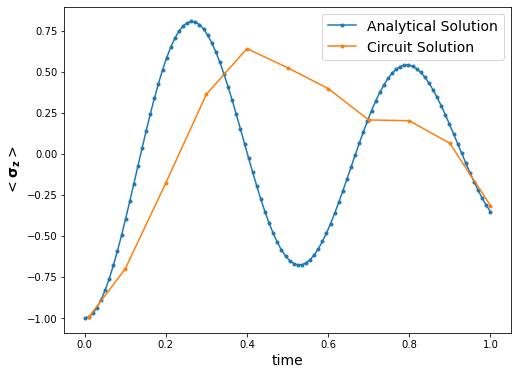

In [32]:
fig = plt.figure(figsize=(8,6))
ax1 = fig.add_subplot(111)

ax1.plot(time_range,avg_pauli_z, '.-', label='Analytical Solution')
ax1.plot([lam**2,10*lam**2,20*lam**2,30*lam**2,40*lam**2,50*lam**2,60*lam**2,70*lam**2,80*lam**2,90*lam**2,100*lam**2],qcavgsig, '.-', label='Circuit Solution')


ax1.set_xlabel('time', fontsize=14)
ax1.set_ylabel('$<\mathbf{\sigma_z}>$', fontsize=14)
ax1.legend(fontsize=14)